## Assignment 4: Model Tuning and Selection, ML App
### Key Findings:
- Comparing between Random Forest and Logistic Regression model performance, we determined that the Random forest model gives better accuracy compared to the logistic regression model.
- The hyperparameters surroudning the decision tree like criterion (gini coefficient and entropy) and the tree depths were tuned to identify the best performing model which yields around 40% of accuracy.
- Tuning the hyperparameters surrounding the Logistic regression surrounding the penalty type, solvers and max iterations didn't yeild better results than the decision tree outcomes

Next steps:
- Enhance the model accuarcy by trying out bagging techniques to increase the performance of the model.
 

In [51]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import csv

In [52]:
# train = np.genfromtxt('train.csv', delimiter=',', dtype=None)
# test = np.genfromtxt('test.csv', delimiter=',', dtype=None)
df = pd.read_csv("train.csv")

In [53]:
print(df.shape)

(318438, 18)


In [54]:
df.head(10)

,case_id,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
0,1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
1,2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
2,3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
3,4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
4,5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
5,6,23,a,6,X,2,anesthesia,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,4449.0,11-20
6,7,32,f,9,Y,1,radiotherapy,S,B,3.0,31397,7.0,Emergency,Extreme,2,51-60,6167.0,0-10
7,8,23,a,6,X,4,radiotherapy,Q,F,3.0,31397,7.0,Trauma,Extreme,2,51-60,5571.0,41-50
8,9,1,d,10,Y,2,gynecology,R,B,4.0,31397,7.0,Trauma,Extreme,2,51-60,7223.0,51-60
9,10,10,e,1,X,2,gynecology,S,E,3.0,31397,7.0,Trauma,Extreme,2,51-60,6056.0,31-40


In [55]:
# basic shape, data type, null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 18 columns):
case_id                              318438 non-null int64
Hospital_code                        318438 non-null int64
Hospital_type_code                   318438 non-null object
City_Code_Hospital                   318438 non-null int64
Hospital_region_code                 318438 non-null object
Available Extra Rooms in Hospital    318438 non-null int64
Department                           318438 non-null object
Ward_Type                            318438 non-null object
Ward_Facility_Code                   318438 non-null object
Bed Grade                            318325 non-null float64
patientid                            318438 non-null int64
City_Code_Patient                    313906 non-null float64
Type of Admission                    318438 non-null object
Severity of Illness                  318438 non-null object
Visitors with Patient                318438 non-null

### Baseline

In [84]:
baseline = pd.DataFrame(df.patientid.groupby([df.Stay]).agg('count').reset_index(name="count"))
baseline['percent'] = (baseline['count'] / baseline['count'].sum()) * 100
baseline

,Stay,count,percent
0,0-10,23604,7.412432
1,11-20,78139,24.538215
2,21-30,87491,27.475050
3,31-40,55159,17.321739
4,41-50,11743,3.687688
5,51-60,35018,10.996803
6,61-70,2744,0.861706
7,71-80,10254,3.220093
8,81-90,4838,1.519291
9,91-100,2765,0.868301


### Decision Tree implementation

In [ ]:
# Prepare the data by separating X and y
# dropping unimportant features, such as passenger id, name, ticket number and cabin number
# note that interesting features might be engieered from the dropped features above

# axis = 1 below means dropping by columns, 0 means by rows
X = df.drop(['Stay', 'case_id'], axis=1)
y = df['Stay']
X.info()

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# any missing values?
X_train.isnull().sum()

In [ ]:
num_features = ['Available Extra Rooms in Hospital', 'Admission_Deposit', 'Visitors with Patient']
cat_features = ['Hospital_code', 'City_Code_Hospital', 'Department', 'Ward_Type', 'City_Code_Patient', 'Type of Admission', 'Severity of Illness', 'Age', 'Bed Grade', 'Hospital_type_code', 'Ward_Facility_Code']

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Create the preprocessing pipeline for numerical features
# There are two steps in this pipeline
# Pipeline(steps=[(name1, transform1), (name2, transform2), ...]) 
# NOTE the step names can be arbitrary

# Step 1 is what we discussed before - filling the missing values if any using mean
# Step 2 is feature scaling via standardization - making features look like normal-distributed 
# see sandardization: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
num_pipeline = Pipeline(
    steps=[
        ('num_imputer', SimpleImputer()),  # we will tune differet strategies later
        ('scaler', StandardScaler()),
        ]
)

# Create the preprocessing pipelines for the categorical features
# There are two steps in this pipeline:
# Step 1: filling the missing values if any using the most frequent value
# Step 2: one hot encoding

cat_pipeline = Pipeline(
    steps=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder()),
    ]
)

# Assign features to the pipelines and Combine two pipelines to form the preprocessor
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_features),
        ('cat_pipeline', cat_pipeline, cat_features),
    ]
)

In [ ]:
# Specify the model to use, which is DecisionTreeClassifier
# Make a full pipeline by combining preprocessor and the model
from sklearn.tree import DecisionTreeClassifier

pipeline_dt = Pipeline(
    steps=[
        ('preprocessor', preprocessor),
        ('clf_dt', DecisionTreeClassifier()),
    ]
)

In [ ]:
# we show how to use GridSearch with K-fold cross validation (K=10) to fine tune the model
# we use the accuracy as the scoring metric with training score return_train_score=True
from sklearn.model_selection import GridSearchCV

# set up the values of hyperparameters you want to evaluate
# here you must use the step names as the prefix followed by two under_scores to sepecify the parameter names and the "full path" of the steps

# we are trying 2 different impputer strategies 
# 2x5 different decision tree models with different parameters
# in total we are trying 2x2x1 = 4 different combinations
param_grid_dt = [ 
    {
        'preprocessor__num_pipeline__num_imputer__strategy': ['mean', 'median'],
        'clf_dt__criterion': ['gini', 'entropy'], 
        'clf_dt__max_depth': [10],
    }
]

# set up the grid search 
grid_search_dt = GridSearchCV(pipeline_dt, param_grid_dt, cv=10, scoring='accuracy', n_jobs = -1)

In [ ]:
# train the model using the full pipeline
grid_search_dt.fit(X_train, y_train)

In [ ]:
# check the best performing parameter combination
grid_search_dt.best_params_

In [ ]:
# build-in CV results keys
sorted(grid_search_dt.cv_results_.keys())

In [ ]:
# test score for the 20 decision tree models
grid_search_dt.cv_results_['mean_test_score']

In [ ]:
# best decistion tree model test score
print(grid_search_dt.best_score_)

### Logistic Regression implemenation

In [11]:
df['patient_city_code'] = df['City_Code_Patient'].apply(lambda x: 8 if pd.isnull(x) else x)
df['bed_grade'] = df['Bed Grade'].apply(lambda x: 3 if pd.isnull(x) else x)

In [12]:
print(df.dropna().shape)

(313793, 20)


In [13]:
df['stay'] = df['Stay'].apply(lambda x: '11-20' if x == '20-Nov' else x)
df['stay'] = df['stay'].apply(lambda x: '>100' if x == 'More than 100 Days' else x)
df.stay[46]

'0-10'

#### Feature Engineering

In [14]:
le = preprocessing.LabelEncoder()

In [15]:
department_encoded=le.fit_transform(df.Department)
age_encoded = le.fit_transform(df.Age)
admission_encoded=le.fit_transform(df['Type of Admission'])
stay_encoded = le.fit_transform(df.stay)
severity_encoded = le.fit_transform(df['Severity of Illness'])
ward_type_encoded = le.fit_transform(df['Ward_Type'])
ward_facility_encoded = le.fit_transform(df['Ward_Facility_Code'])
hospital_region_encoded = le.fit_transform(df['Hospital_region_code'])
hospital_type_encoded = le.fit_transform(df['Hospital_type_code'])

In [16]:
df['department_encoded'] = department_encoded
df['age_encoded'] = age_encoded
df['admission_encoded'] = admission_encoded
df['stay_encoded'] = stay_encoded
df['severity_encoded'] = severity_encoded
df['ward_type_encoded'] = ward_type_encoded
df['ward_facility_encoded'] = ward_facility_encoded
df['hospital_region_encoded'] = hospital_region_encoded
df['hospital_type_encoded'] = hospital_type_encoded

In [17]:
X = df[['Visitors with Patient','Admission_Deposit','Available Extra Rooms in Hospital','age_encoded','admission_encoded', 'severity_encoded','Hospital_code','hospital_type_encoded','ward_type_encoded', 'ward_facility_encoded', 'patientid']]
y = df['Stay']

In [18]:
visit_count = pd.DataFrame(X['patientid'].groupby(X.patientid).agg('count').reset_index(name="visit_count"))
visit_count.columns
# visit_count

Index(['patientid', 'visit_count'], dtype='object')

In [19]:
X = X.join(visit_count.set_index('patientid'), lsuffix='_caller', on='patientid', sort='true')
X.columns

Index(['Visitors with Patient', 'Admission_Deposit',
       'Available Extra Rooms in Hospital', 'age_encoded', 'admission_encoded',
       'severity_encoded', 'Hospital_code', 'hospital_type_encoded',
       'ward_type_encoded', 'ward_facility_encoded', 'patientid',
       'visit_count'],
      dtype='object')

In [20]:
X['visit_count'] = X['visit_count'].fillna(0)
X['visit_count'] 

254952     4
254953     4
254954     4
254955     4
71206      2
71207      2
287854     2
287855     2
200546     1
296761     4
296762     4
296763     4
296764     4
140427     2
140428     2
307092     2
307093     2
287869     3
287870     3
287871     3
307541     2
307542     2
250119     1
237630     4
237631     4
237632     4
237633     4
201409     2
201410     2
55479     12
          ..
108096     6
298784     2
298785     2
137951     6
137952     6
137953     6
137954     6
137955     6
137956     6
173093     9
173094     9
173095     9
173096     9
173097     9
173098     9
173099     9
173100     9
173101     9
138640     3
138641     3
138642     3
280165     4
280166     4
280167     4
280168     4
270876     2
270877     2
199911     3
199912     3
199913     3
Name: visit_count, Length: 318438, dtype: int64

In [21]:
X = X.drop(['visit_count'], axis=1)

In [22]:
# num_features = ['Visitors with Patient','Admission_Deposit','Available Extra Rooms in Hospital','visit_count','patientid']
num_features = ['Visitors with Patient','Admission_Deposit','Available Extra Rooms in Hospital','patientid']
cat_features = ['age_encoded','admission_encoded', 'severity_encoded','Hospital_code','hospital_type_encoded','ward_type_encoded', 'ward_facility_encoded']

#### Logistic Regression Model pipeline

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder


num_pipeline = Pipeline(
    steps=[
        ('num_imputer', SimpleImputer()),  # we will tune differet strategies later
        ('scaler', StandardScaler()),
        ]
)

cat_pipeline = Pipeline(
    steps=[
        ('cat_imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder()),
#         ('scaler', StandardScaler()),        
    ]
)

# Assign features to the pipelines and Combine two pipelines to form the preprocessor
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num_pipeline', num_pipeline, num_features),
        ('cat_pipeline', cat_pipeline, cat_features),
    ]
)

In [29]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
#         ('pca', pca), 
        ('logistic', logistic)])

In [30]:
# This method will allow us to know how long running the model takes,
# each time it runs.
import datetime
from datetime import timedelta

def timediff(s1,s2):
    datetimeFormat = '%H:%M:%S'
    diff = datetime.datetime.strptime(str(s2), datetimeFormat)\
        - datetime.datetime.strptime(str(s1), datetimeFormat)
    return diff

In [31]:
param_grid = [    
    {
    'logistic__penalty' : ['l1','l2', 'elasticnet', 'none'],
    'logistic__C' : np.logspace(-4, 4, 20),
    'logistic__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'logistic__max_iter' : [100, 1000,2500, 5000]
    }
]

param_grid1 = [    
    {
    'logistic__penalty' : ['l2','none'],    
    'logistic__solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    'logistic__max_iter' : [100, 200]
    }
]

param_grid2 = [    
    {
    'logistic__penalty' : ['l1'],    
    'logistic__solver' : ['liblinear','saga'],
    'logistic__max_iter' : [100, 200]
    }
]

param_grid3 = [    
    {
    'logistic__penalty' : ['elasticnet'],    
    'logistic__solver' : ['saga'],
    'logistic__max_iter' : [100, 200]
    }    
]

In [32]:
s1 = datetime.datetime.now().time().strftime('%H:%M:%S') # START
print(s1)
estimator = GridSearchCV(pipe,param_grid2,cv=3, scoring='accuracy', verbose=True, n_jobs=-1)
estimator.fit(X, y)
s2 = datetime.datetime.now().time().strftime('%H:%M:%S') # FINISH
print(s2)
print("\n\nElapsed time (HH:MM:SS): ", timediff(s1,s2))

15:51:57
Fitting 3 folds for each of 4 candidates, totalling 12 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  12 | elapsed: 146.6min finished


18:21:25


Elapsed time (HH:MM:SS):  2:29:28


C:\Users\siva_\anaconda3\envs\misy630\lib\site-packages\sklearn\linear_model\_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


#### Model evaluation

In [33]:
estimator.best_params_

{'logistic__max_iter': 100,
 'logistic__penalty': 'l1',
 'logistic__solver': 'saga'}

In [34]:
sorted(estimator.cv_results_.keys())

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_logistic__max_iter',
 'param_logistic__penalty',
 'param_logistic__solver',
 'params',
 'rank_test_score',
 'split0_test_score',
 'split1_test_score',
 'split2_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [35]:
estimator.cv_results_['mean_test_score']

array([0.26569379, 0.26572834, 0.26568751, 0.26570321])

In [36]:
estimator.best_score_

0.2657283364422588

In [37]:
print("tuned hpyerparameters :(best parameters) ",estimator.best_params_)
print (f'Accuracy - : {estimator.best_score_:.3f}')

SyntaxError: invalid syntax (<ipython-input-37-98be7dc9a097>, line 2)

In [38]:
clf_best = estimator.best_estimator_
clf_best

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num_pipeline',
                                                  Pipeline(memory=None,
                                                           steps=[('num_imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='mean',
                                                  

In [39]:
clf_best.named_steps

{'logistic': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                    intercept_scaling=1, l1_ratio=None, max_iter=100,
                    multi_class='auto', n_jobs=None, penalty='l1',
                    random_state=None, solver='saga', tol=0.0001, verbose=0,
                    warm_start=False),
 'preprocessor': ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                   transformer_weights=None,
                   transformers=[('num_pipeline',
                                  Pipeline(memory=None,
                                           steps=[('num_imputer',
                                                   SimpleImputer(add_indicator=False,
                                                                 copy=True,
                                                                 fill_value=None,
                                                                 missing_values=nan,
                       

In [40]:
clf_best['logistic']

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

IndexError: index 35 is out of bounds for axis 1 with size 11

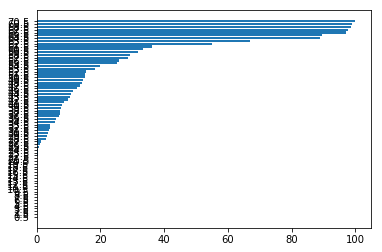

In [41]:
feature_importance = abs(clf_best['logistic'].coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure()
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()